In [40]:
import math
import random

In [144]:
class Value:

    def __init__ (self, data, _children=(), _op='', label=''):
        self.data=data
        self._prev=set(_children)
        self._op=_op
        self._backward=lambda: None
        self.label=label
        self.grad=0.0

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out=Value(self.data+other.data, (self,other), '+')

        def _backward():
            self.grad += 1.0*out.grad
            other.grad += 1.0*out.grad
        out._backward=_backward
        return out

    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data*other.data, (self,other), '*')

        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._backward=_backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only for int/float"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other*(self.data**(other-1)) * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self *other

    def __truediv__(self,other):
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return other + (-self)
    
    def tanh(self):
        x=self.data
        t=(math.exp(2*x) -1)/(math.exp(2*x)+1)
        out=Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1-t**2)*out.grad
        out._backward=_backward
        return out

    def exp(self):
        x=self.data
        out=Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):
        #print(self)
        topo=[]
        visited=set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad=1.0
        for node in reversed(topo):
            node._backward()

In [15]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot=Digraph(format='svg', graph_attr={'rankdir':"LR"})
    nodes, edges = trace(root)
    for n in nodes:
        uid=str(id(n))
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op,uid)
    for n1,n2 in edges:
        dot.edge(str(id(n1)), str(id(n2))+n2._op)

    return dot

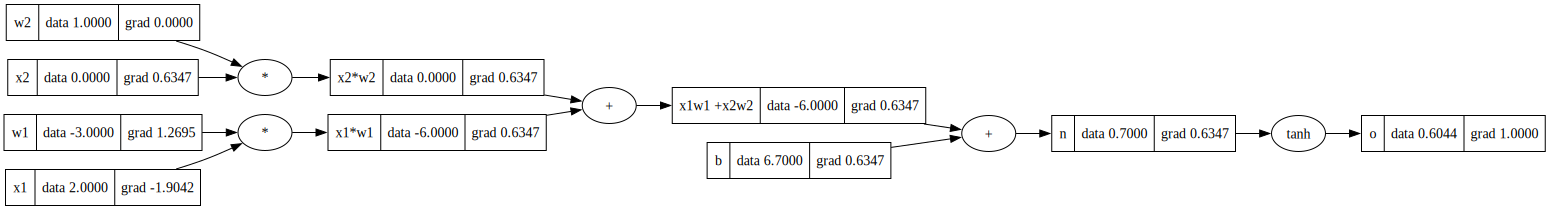

In [23]:
draw_dot(o)

In [104]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [147]:
c = [1.0,2.0,3.0]
n = MLP(3, [4,4,1])
n(c)

Value(data=0.03775566818945642)

In [148]:
xs = [
    [1.0,-2.0,3.0],
    [3.0,8.0,9.0],
    [-4.0,7.0,3.0],
    [5.0,6.0,-2.0]
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.7504654787562511),
 Value(data=0.07600874343924834),
 Value(data=0.13540697999053158),
 Value(data=0.2684341595977338)]

In [149]:
for k in range(20):
    
    ypred = [n(x) for x in xs]
    loss = sum(((y2 - y1)**2 for y1, y2 in zip(ys, ypred)))

    for p in n.parameters():
        p.data += 0*p.grad

    loss.backward()

    for p in n.parameters():
        p.data += -0.01*p.grad

    print(k, loss)

0 Value(data=6.046261797329755)
1 Value(data=5.26558940257263)
2 Value(data=4.292283600316314)
3 Value(data=3.7912897209040066)
4 Value(data=3.609580066687982)
5 Value(data=3.549465854107269)
6 Value(data=3.5069900801519616)
7 Value(data=3.4464365572236053)
8 Value(data=3.353349714905002)
9 Value(data=3.1991355477140946)
10 Value(data=2.9013358862749716)
11 Value(data=2.3009224375690245)
12 Value(data=1.374811096504432)
13 Value(data=0.6827609160008048)
14 Value(data=0.621479492240133)
15 Value(data=0.9133208002131512)
16 Value(data=1.0027645425515899)
17 Value(data=0.5094914873201317)
18 Value(data=0.09983218032142763)
19 Value(data=0.044011155492668624)


In [18]:
##PRACTICE BELOW!!!!!!

In [26]:
import torch

In [34]:
s1 = torch.Tensor([2.0]).double() ;s1.requires_grad = True
s2 = torch.Tensor([0.0]).double() ;s2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ;w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ;w2.requires_grad = True
b = torch.Tensor([6.88]).double(); b.requires_grad = True
n = s1*w1  + s2*w2 + b
o= torch.tanh(n)

print(o.data.item())
o.backward()
print('x2', s2.grad.item())
print('w2', w2.grad.item())
print('x1', s1.grad.item())
print('w2', w2.grad.item())

0.7064193777288968
x2 0.5009716627691181
w2 0.0
x1 -1.5029149883073543
w2 0.0


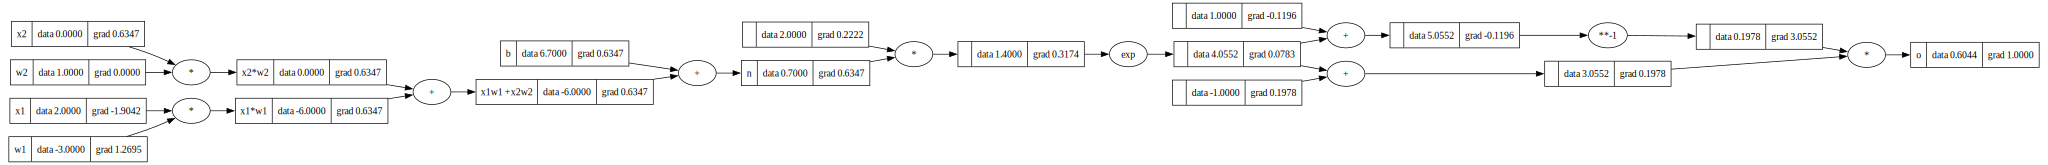

In [25]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.7, label='b')

x1w1=x1*w1; x1w1.label='x1*w1'
x2w2=x2*w2; x2w2.label='x2*w2'

x1w1x2w2 = x1w1 +x2w2 ; x1w1x2w2.label='x1w1 +x2w2'
n = x1w1x2w2+b; n.label='n'
#------
#replace the below with actualy def
#o=n.tanh()
e = (2*n).exp()
o = (e-1)/(e+1)
#------
o.label='o'
o.backward()
draw_dot(o)

In [21]:
a-p

Value(data=-1.0)

In [19]:
a=Value(2.0)
p=Value(3.0)
a/p

Value(data=0.6666666666666666)

In [264]:
a=Value(2.0)
a.exp()

Value(data=7.38905609893065)

In [247]:
def lol():
    h=0.0001
    a=Value(2.0, label='a')
    b=Value(-3.0, label='b')
    c=Value(10.0, label='c')
    e=a*b;e.label='e'
    d=e+c
    d.label='d'
    f=Value(-2.0, label="f")
    L=d*f; L.label = 'L'
    L1=L.data

    a=Value(2.0+h, label='a')
    b=Value(-3.0, label='b')
    c=Value(10.0, label='c')
    e=a*b;e.label='e'
    d=e+c
    d.label='d'
    f=Value(-2.0, label="f")
    L=d*f; L.label = 'L'
    L2=L.data
    print((L2-L1)/h)
    print('L1',L1)
    a.grad=6.0
    b.grad=-4.0
    e.grad=-2.0
    c.grad=-2.0
    d.grad=4.0
    L.grad=1.0
    
lol()

6.000000000021544
L1 -8.0


In [235]:
import math

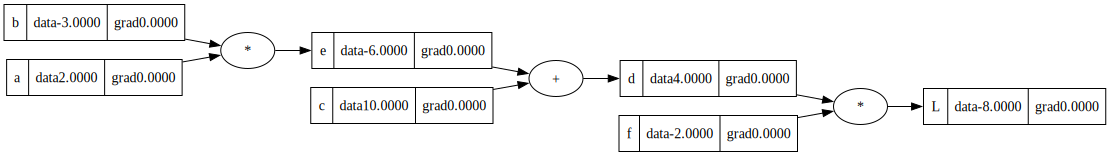

In [236]:
draw_dot(L)

In [157]:
a.grad=6.0
b.grad=-4.0
e.grad=-2.0
c.grad=-2.0
d.grad=4.0
L.grad=1.0

In [158]:
a.data += 0.1 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

In [159]:
a

Value(data=2.6, _children=set())

In [160]:
e= a * b
d= e + c
L= d * f
print(L.data)

-4.151999999999999


In [242]:
o.backward()

In [243]:
o.grad=1.00

In [164]:
#do/dn = 1-o**2
n.grad = 1-o.data**2

In [165]:
x1w1x2w2.grad=n.grad
b.grad=n.grad


In [166]:
x1w1.grad=n.grad
x2w2.grad=n.grad

In [167]:
x2.grad=w2.data*x2w2.grad
w2.grad=x2.data*x2w2.grad

In [168]:
x1.grad=w1.data*x1w1.grad
w1.grad=x1.data*x1w1.grad

In [169]:
o

Value(data=0.6043677771171636, _children={Value(data=0.7000000000000002, _children={Value(data=6.7, _children=set()), Value(data=-6.0, _children={Value(data=0.0, _children={Value(data=0.0, _children=set()), Value(data=1.0, _children=set())}), Value(data=-6.0, _children={Value(data=2.0, _children=set()), Value(data=-3.0, _children=set())})})})})

In [180]:
o._backward()

In [183]:
n._backward()

In [184]:
x1w1x2w2._backward()

In [185]:
x1w1._backward()

In [187]:
x2w2._backward()

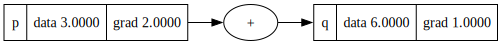

In [255]:
p = Value(3.0, label='p')
q=p+p; q.label='q'
q.backward()
draw_dot(q)